<a href="https://colab.research.google.com/github/hardik-kumar-10/Learning-Probability-Density-Functions-using-data-only/blob/main/Assignment_4_Predictive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load CSV safely
dataframe = pd.read_csv(
    "Data_1.csv",
    encoding="latin1",
    engine="python",
    on_bad_lines="skip"
)

# Extract and process NO2 column
no2_data = dataframe["no2"].dropna().to_numpy().reshape(-1, 1)

scaler = StandardScaler()
no2_scaled = scaler.fit_transform(no2_data)

# Transformation logic
roll_number = 102317054
alpha = 0.5 * (roll_number % 7)
beta = 0.3 * ((roll_number % 5) + 1)

z_values = no2_scaled + alpha * np.sin(beta * no2_scaled)
z_tensor = torch.tensor(z_values, dtype=torch.float32)


In [3]:
# Model Architectures

class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        )

    def forward(self, input_tensor):
        return self.layers(input_tensor)


class DiscriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input_tensor):
        return self.layers(input_tensor)



generator = GeneratorNet()
discriminator = DiscriminatorNet()

loss_fn = nn.BCELoss()

opt_discriminator = optim.Adam(discriminator.parameters(), lr=2e-4)
opt_generator = optim.Adam(generator.parameters(), lr=2e-4)


In [4]:
num_epochs = 5000
batch_size = 128

for epoch in range(num_epochs):

    # ===== Train Discriminator =====
    discriminator.zero_grad()

    # Real samples
    indices = np.random.choice(z_tensor.shape[0], batch_size, replace=False)
    real_batch = z_tensor[indices]

    real_labels = torch.ones(batch_size, 1)
    real_output = discriminator(real_batch)
    loss_real = loss_fn(real_output, real_labels)

    # Fake samples
    noise = torch.randn(batch_size, 1)
    fake_batch = generator(noise)

    fake_labels = torch.zeros(batch_size, 1)
    fake_output = discriminator(fake_batch.detach())
    loss_fake = loss_fn(fake_output, fake_labels)

    # Total discriminator loss
    d_loss = loss_real + loss_fake
    d_loss.backward()
    opt_discriminator.step()

    # ===== Train Generator =====
    generator.zero_grad()

    gen_output = discriminator(fake_batch)
    g_loss = loss_fn(gen_output, real_labels)
    g_loss.backward()
    opt_generator.step()

    # Logging
    if epoch % 1000 == 0:
        print(
            f"Epoch [{epoch}/{num_epochs}] | "
            f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}"
        )

Epoch [0/5000] | D Loss: 1.3882 | G Loss: 0.7935
Epoch [1000/5000] | D Loss: 1.3832 | G Loss: 0.7036
Epoch [2000/5000] | D Loss: 1.3516 | G Loss: 0.7292
Epoch [3000/5000] | D Loss: 1.3596 | G Loss: 0.7058
Epoch [4000/5000] | D Loss: 1.3869 | G Loss: 0.6988


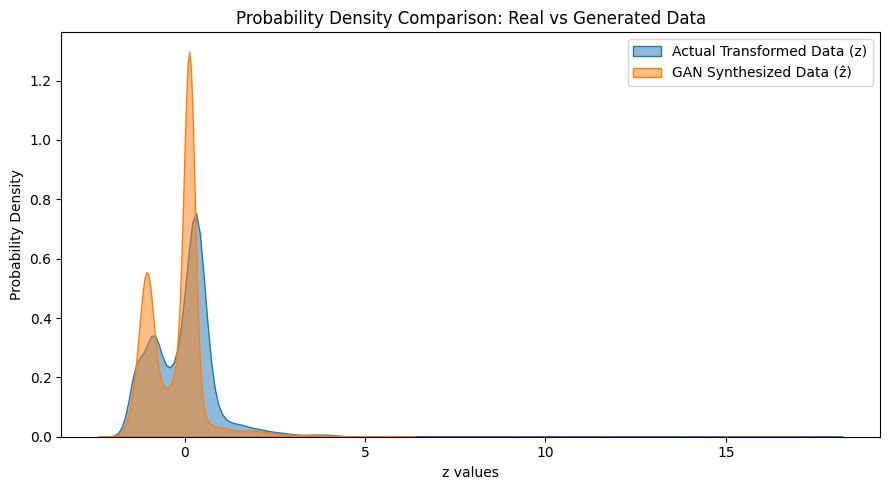

In [5]:
# Results & Visualization

generator.eval()

with torch.no_grad():
    noise_samples = torch.randn(8000, 1)   # slightly different size
    synthetic_z = generator(noise_samples).cpu().numpy()

plt.figure(figsize=(9, 5))

# Density plots
sns.kdeplot(
    z_tensor.numpy().ravel(),
    label="Actual Transformed Data (z)",
    fill=True,
    alpha=0.5,
    bw_adjust=1.1
)

sns.kdeplot(
    synthetic_z.ravel(),
    label="GAN Synthesized Data (ẑ)",
    fill=True,
    alpha=0.5,
    bw_adjust=1.1
)

plt.title("Probability Density Comparison: Real vs Generated Data")
plt.xlabel("z values")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()
